In [2]:
import os
import random
from collections import Counter
from IPython.display import clear_output
from tqdm import tqdm, trange

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
from torchsummary import summary
from torchtext.datasets import IMDB
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import GloVe, FastText, Vocab

import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_curve, auc

from utils import *

In [ ]:
os.environ['CUDA_VISIBLE_DEVICES'] = '2, 3, 4'

In [3]:
if torch.cuda.is_available():
    torch.cuda.set_device(0)
    DEVICE = torch.device('cuda:0')
else:
    DEVICE = torch.device('cpu')
DEVICE

device(type='cuda', index=0)

The way of working with torchtext.datasets has changed in torchtext version 0.9.0, so we changed the part of data preparation in this notebook. Dataset is now loaded as raw data, but there are good tokenization tools to form a vocabulary. We will start by following the pipeline described in torchtext migration tutorial (https://github.com/pytorch/text/blob/master/examples/legacy_tutorial/migration_tutorial.ipynb).

In [4]:
train_data, test_data = IMDB(split=('train', 'test'))

aclImdb_v1.tar.gz: 100%|██████████| 84.1M/84.1M [00:01<00:00, 49.0MB/s]


In [5]:
tokenizer = get_tokenizer('basic_english')

In [6]:
train_iter = IMDB(split='train')
counter = Counter()
for (label, line) in train_iter:
    counter.update(tokenizer(line))
vocab = Vocab(counter, min_freq=10, specials=('<unk>', '<BOS>', '<EOS>', '<PAD>'))

In [7]:
print("The length of the new vocab is", len(vocab))
print("The index of '<BOS>' is", vocab.stoi['<BOS>'])
print("The token at index 2 is", vocab.itos[2])

The length of the new vocab is 20439
The index of '<BOS>' is 1
The token at index 2 is <EOS>


In [8]:
text_transform = lambda x: [vocab['<BOS>']] + [vocab[token] for token in tokenizer(x)] + [vocab['<EOS>']]
label_transform = lambda x: 1 if x == 'pos' else 0

print("input to the text_transform:", "here is an example")
print("output of the text_transform:", text_transform("here is an example"))

input to the text_transform: here is an example
output of the text_transform: [1, 134, 12, 43, 467, 2]


Since we work with batches of texts presented as word sequences, a good idea is to look at text lengths distributions. To avoid some problems with GPU memory consumptions we do not actually want to have batches of size 5 times greater than most of texts in dataset because of some very long texts.

In [9]:
lengths = [len(text_transform(example[1])) for example in train_data]

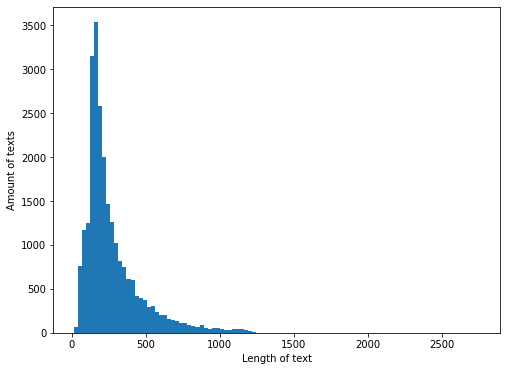

88% percentile: 489.119999999999


In [10]:
plt.figure(figsize=(8, 6))
plt.hist(lengths, bins=100)
plt.xlabel('Length of text')
plt.ylabel('Amount of texts')
plt.show()
n = 88
print(f'{n}% percentile: {np.percentile(lengths, n)}')

While loading data in train loop we will clip all batches to have length not greater than 500. It affects not more than 12% texts and such length is anough large to contain a lot of information even for long texts. Now let's create train, validation and test dataloaders.

In [15]:
def collate_batch(batch):
    label_list, text_list = [], []
    for (label, text) in batch:
        label_list.append(label)
        processed_text = torch.tensor(text)
        text_list.append(processed_text)
    return torch.tensor(label_list), pad_sequence(text_list, padding_value=3.0, batch_first=True)

In [16]:
def preprocess_data_from_iter(data_iter):
    return list(map(lambda x: (label_transform(x[0]), text_transform(x[1])), data_iter))

In [17]:
train_iter = IMDB(split='train')
data = preprocess_data_from_iter(train_iter)
random.shuffle(data)

val_size = len(train_iter) // 10
train_data, val_data = data[:-val_size], data[-val_size:]

train_dataloader = DataLoader(train_data, batch_size=32, shuffle=True, 
                              collate_fn=collate_batch, drop_last=True)

val_dataloader = DataLoader(val_data, batch_size=32, shuffle=True, 
                            collate_fn=collate_batch, drop_last=True)

In [19]:
test_iter = IMDB(split='test')
test_dataloader = DataLoader(preprocess_data_from_iter(test_iter), batch_size=32, shuffle=False, 
                             collate_fn=collate_batch)

In [20]:
len(train_dataloader), len(val_dataloader), len(test_dataloader)

(703, 78, 782)

In [21]:
for batch in train_dataloader:
    print(f'Labels: {batch[0]}')
    print(f'Texts: {batch[1]}')
    break

Labels: tensor([0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1,
        1, 1, 0, 0, 1, 1, 0, 1])
Texts: tensor([[  1,   0,   0,  ...,   3,   3,   3],
        [  1,  15,  11,  ...,   3,   3,   3],
        [  1,  37,   9,  ...,   3,   3,   3],
        ...,
        [  1,  56, 514,  ...,   3,   3,   3],
        [  1,  82, 285,  ...,   3,   3,   3],
        [  1,  16,  25,  ...,   3,   3,   3]])


We are going to implement our own attention layer that calculates scalar products of request with input elements and takes softmax of obtained values as attention weights. Than it forms attention output for request as linear combination of elements with attention weights.

In [88]:
class AttentionLayer(nn.Module):
    def __init__(self, name):
        super().__init__()
        self.name = name
        self.minus_inf = torch.tensor([-1e9], dtype=torch.float32)   
        

    def forward(self, input, input_mask, request):
        logits = torch.sum(input * request, dim=2)
        assert logits.shape == (input.shape[0], input.shape[1]), logits.shape

        logits_masked = torch.where(input_mask == 0, self.minus_inf.to(logits.device), logits) # [batch_size, sentence_len]

        probs = F.softmax(logits_masked, dim=-1).unsqueeze(2) # [batch_size, sentence_len, 1]

        attn = torch.sum(input * probs, dim=1) # [batch_size, input_size]
        
        return attn, probs.squeeze()

Our first model will be modification of *LSTM model* from previous notebook. It will use *AttentionLayer* to change lstm outputs of *\<EOS\>* positions by applying attention for them as request.

In [89]:
class LSTMAttentiveModel(nn.Module):
    def __init__(self, vocab_size=len(vocab), emb_size=300, hidden_size=256):
        super().__init__()
        self.name = 'LSTM neural network with attention'
        self.eos_idx = 1

        self.embeddings = nn.Embedding(num_embeddings=vocab_size, embedding_dim=emb_size)
        self.lstm = nn.LSTM(input_size=emb_size, hidden_size=hidden_size, batch_first=True)
        self.attention = AttentionLayer('Attention')

        self.linear_head = nn.Sequential(
            nn.Linear(hidden_size, 256),
            nn.Dropout(p=0.4),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.Dropout(p=0.4),
            nn.ReLU(),
            nn.Linear(128, 2)
        )

    def forward(self, input):
        text_embeddings = self.embeddings(input.to(DEVICE)) # [batch_size, sentence_len, emb_size]
        mask = self._compute_mask(input).to(DEVICE) # [batch_size, sentence_len]

        lstm_output, _ = self.lstm(text_embeddings) # [batch_size, sentence_len, hid_size]

        is_eos = (input == vocab.stoi['<EOS>']).unsqueeze(2).to(DEVICE)
        request = torch.sum(lstm_output * is_eos, dim=1).unsqueeze(1)
        
        attention_output, _ = self.attention(lstm_output, mask, request) # [batch_size, hid_size]
        output = self.linear_head(attention_output) # [batch_size, 2]
        return output

    def predict(self, input):
        return torch.argmax(self.forward(input), dim=1)

    def _compute_mask(self, input):
        return input != vocab.stoi['<PAD>']

Let's train our first attentive model and print the results:

In [ ]:
model = LSTMAttentiveModel().to(DEVICE)
optim = Adam(model.parameters(), lr=1e-3)

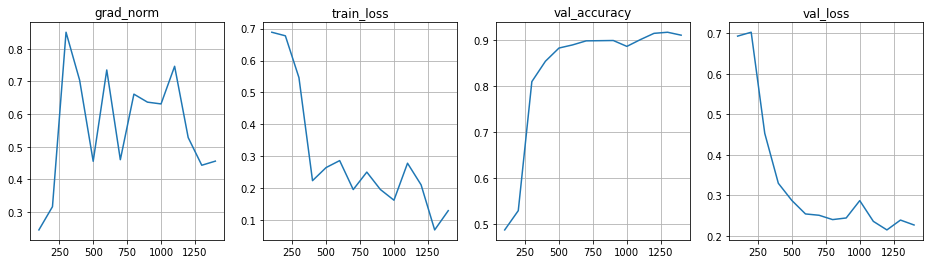

Mean loss=0.170


100%|██████████| 2/2 [04:21<00:00, 130.65s/it]


In [ ]:
train_model(model, optim, train_dataloader, val_dataloader, device=DEVICE, n_epochs=2)

Scores for LSTM neural network with attention:
Accuracy: 0.9586148648648649
Precision: 0.9387928111224144
Recall: 0.9814765576531065
Area under ROC-curve: 0.9932


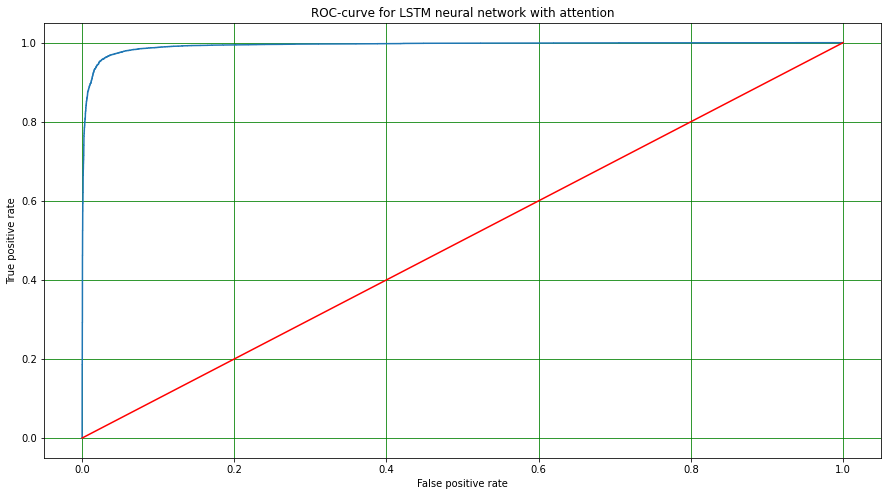

In [ ]:
get_scores(model, train_dataloader, print_scores=True, from_iter=True)
plot_roc_curve(model, train_dataloader)

Scores for LSTM neural network with attention:
Accuracy: 0.88872
Precision: 0.8630996861455686
Recall: 0.924
Area under ROC-curve: 0.9554


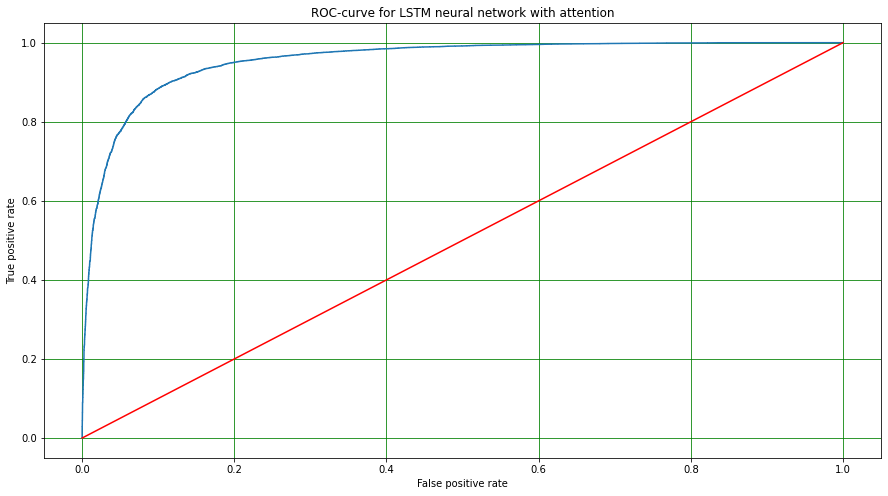

In [ ]:
get_scores(model, test_dataloader, print_scores=True, from_iter=True)
plot_roc_curve(model, test_dataloader)

The scores are really good: our model has better accuracy, recall and roc-auc score than all previous models.


We can also try to build attentive model based on GRU and check if it also significantly increases quality.

In [ ]:
class GRUAttentiveModel(nn.Module):
    def __init__(self, vocab_size=len(vocab), emb_size=300, hidden_size=256):
        super().__init__()
        self.name = 'GRU neural network with attention'
        self.eos_idx = 1

        self.embeddings = nn.Embedding(num_embeddings=vocab_size, embedding_dim=emb_size)
        self.gru = nn.GRU(input_size=emb_size, hidden_size=hidden_size, batch_first=True)
        self.attention = AttentionLayer('Attention')

        self.linear_head = nn.Sequential(
            nn.Linear(hidden_size, 256),
            nn.Dropout(p=0.4),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.Dropout(p=0.4),
            nn.ReLU(),
            nn.Linear(128, 2)
        )

    def forward(self, input):
        text_embeddings = self.embeddings(input.to(DEVICE)) # [batch_size, sentence_len, emb_size]
        mask = self._compute_mask(input).to(DEVICE) # [batch_size, sentence_len]

        attn_mask = mask # [batch_size, sentence_len]

        gru_output, _ = self.gru(text_embeddings) # [batch_size, sentence_len, hid_size]

        is_eos = (input == vocab.stoi['<EOS>']).unsqueeze(2).to(DEVICE)
        
        request = torch.sum(gru_output * is_eos, dim=1).unsqueeze(1)
        
        attention_output, _ = self.attention(gru_output, attn_mask, request) # [batch_size, hid_size]
        
        output = self.linear_head(attention_output) # [batch_size, 2]
        return output

    def predict(self, input):
        return torch.argmax(self.forward(input), dim=1)

    def _compute_mask(self, input):
        return input != vocab.stoi['<PAD>']

In [ ]:
model = GRUAttentiveModel().to(DEVICE)
optim = Adam(model.parameters(), lr=1e-3)

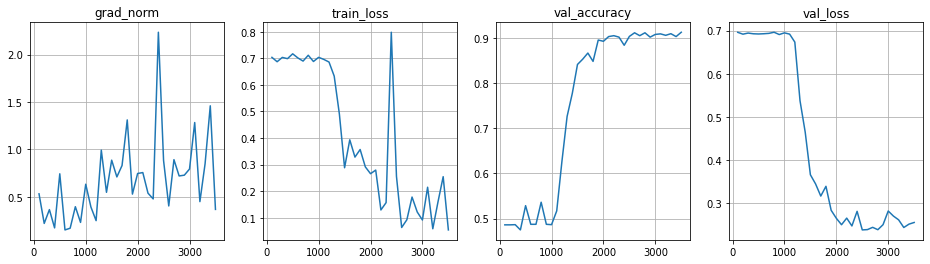

Mean loss=0.148


100%|██████████| 5/5 [11:45<00:00, 141.09s/it]


In [ ]:
train_model(model, optim, train_dataloader, val_dataloader, device=DEVICE, n_epochs=5)

Scores for GRU neural network with attention:
Accuracy: 0.9829302987197724
Precision: 0.9851317663817664
Recall: 0.9807658216628258
Area under ROC-curve: 0.9971


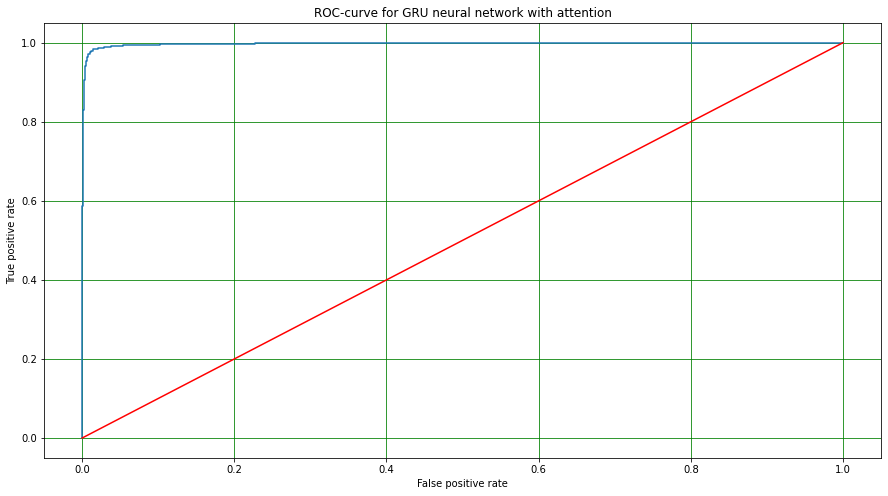

In [ ]:
get_scores(model, train_dataloader, print_scores=True, from_iter=True)
plot_roc_curve(model, train_dataloader)

Scores for GRU neural network with attention:
Accuracy: 0.88808
Precision: 0.89664758789861
Recall: 0.87728
Area under ROC-curve: 0.9512


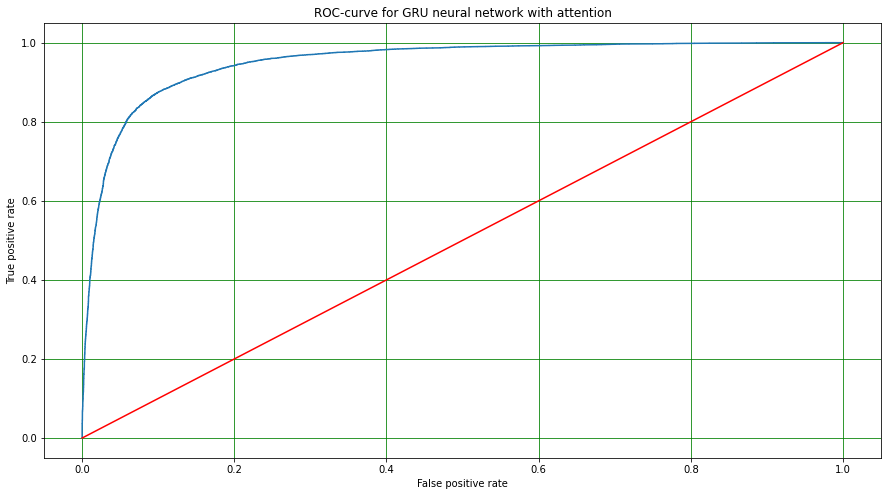

In [ ]:
get_scores(model, test_dataloader, print_scores=True, from_iter=True)
plot_roc_curve(model, test_dataloader)

GRU network with attention also has great scores. Its accuracy and roc-auc score is almost as high as for LSTM model with attention, it also has good precision. We can also notice that it took more time for such model to train, because a good quality growth started only after 2 epochs.


We can now make scores table with new models and compare them all:

Model                      | Accuracy | Precision | Recall | Roc-auc
---------------------------|----------|-----------|--------|--------
LogisticRegression         | 0.861    | 0.862     | 0.860  | 0.932
Fully-connected NN         | 0.880    | 0.865     | 0.901  | 0.949
CNN                        | 0.869    | 0.861     | 0.881  | 0.944
LSTM-based NN              | 0.852    | 0.879     | 0.817  | 0.928
GRU-based NN               | 0.850    | 0.907     | 0.781  | 0.935
LSTM-based NN + attention  | 0.889    | 0.863     | 0.924  | 0.955
GRU-based NN + attention   | 0.888    | 0.897     | 0.877  | 0.951
